In [ ]:
import operator
from typing import Annotated, Any
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.messages import HumanMessage
from src.docker_wrapper.schemas import ContainerStats, DockerSystemDF
from langgraph.graph import StateGraph
from langgraph.types import RetryPolicy
from langchain.agents import create_agent

# Логирование

In [29]:
import logging

logger = logging.getLogger('DockerAgent')

# Модели - парсеры

In [30]:
class DockerQuery(BaseModel):
    """Модель описывающая исходный запрос"""
    task: str = Field(..., description="The Docker monitoring task to perform")
    include_stopped: bool = Field(
        default=False, 
        description="Whether to include stopped containers in analysis"
    )
    max_containers: int = Field(
        default=10, 
        description="Maximum number of containers to analyze"
    )

class DockerPlan(BaseModel):
    """Модель для планировщика"""
    container_queries: list[str] = Field(
        ..., description="List of container analysis tasks to perform"
    )
    system_queries: list[str] = Field(
        ..., description="List of system-wide analysis tasks to perform"
    )
    focus_areas: list[str] = Field(
        ..., description="Key focus areas for Docker monitoring (CPU, memory, network, disk, etc.)"
    )

class ContainerStatsFindings(BaseModel):
    """Статистики контейнеров"""
    containers: list[ContainerStats] = Field(
        default_factory=list, 
        description="List of container statistics with detailed metrics"
    )

class SystemDFFindings(BaseModel):
    """Использование памяти докером"""
    system_df: DockerSystemDF = Field(
        ..., description="System-wide disk usage information"
    )

class DockerSummary(BaseModel):
    summary_text: str = Field(..., description="Beautiful, human-readable summary of the Docker monitoring report")

class DockerReport(BaseModel):
    """Результат"""
    task: str = Field(..., description="Original monitoring task")
    key_findings: list[str] = Field(..., description="List of key findings from monitoring")
    summary: str = Field(..., description="Overall summary of Docker system health")
    recommendations: list[str] = Field(
        default_factory=list, 
        description="Recommendations for optimization and cleanup"
    )
    needs_additional_analysis: bool = Field(
        default=False,
        description="Whether additional analysis is needed to complete the report"
    )

# Обший стейт и парсеры


In [31]:
class DockerState(BaseModel):
    query: DockerQuery
    plan: DockerPlan | None = None
    container_stats: Annotated[list[ContainerStats], operator.add] = Field(
        default_factory=list
    )
    system_df: DockerSystemDF | None = None
    report: DockerReport | None = None
    errors: Annotated[list[str], operator.add] = Field(default_factory=list)
    iteration: int = 0

planner_parser = PydanticOutputParser(pydantic_object=DockerPlan)
container_stats_parser = PydanticOutputParser(pydantic_object=ContainerStatsFindings)
system_df_parser = PydanticOutputParser(pydantic_object=SystemDFFindings)
synthesizer_parser = PydanticOutputParser(pydantic_object=DockerReport)
summary_parser = PydanticOutputParser(pydantic_object=DockerSummary)

# Промпты

In [32]:
from src.prompts import PLANNER_PROMPT, SUMMARY_PROMPT, SYNTHESIZER_PROMPT, CONTAINER_STATS_PARSER_PROMPT, SYSTEM_DF_PARSER_PROMPT

# Получим инстанс LLM

In [33]:
from src.utils import get_llm


llm = get_llm()

# Граф

In [34]:
from src.tools import container_stats, list_containers, system_df


container_stats_agent = create_agent(llm, [list_containers, container_stats], system_prompt=CONTAINER_STATS_PROMPT)
system_df_agent = create_agent(llm, [system_df], system_prompt=SYSTEM_DF_PROMPT)

In [35]:
async def planner_node(state: DockerState) -> dict[str, Any]:
    logger.info(f"planner: {state.query.task}")
    messages = PLANNER_PROMPT.format_messages(
        format_instructions=planner_parser.get_format_instructions(),
        task=state.query.task,
        include_stopped=state.query.include_stopped,
        max_containers=state.query.max_containers,
    )
    response = await llm.ainvoke(messages)
    plan = planner_parser.parse(response.content)
    logger.info(f"planner: {len(plan.container_queries)} container queries, {len(plan.system_queries)} system queries")
    return {"plan": plan}

In [ ]:
async def container_stats_researcher_node(state: DockerState) -> dict[str, Any]:
    if not state.plan:
        raise ValueError("No monitoring plan available")

    logger.info(f"container_stats_researcher: analyzing containers")
    
    message = HumanMessage(
        content=f"List containers to monitor. Include stopped containers: {state.query.include_stopped}"
    )
    agent_response = await container_stats_agent.ainvoke({"messages": [message]})
    agent_output = agent_response["messages"][-1].content

    chain = CONTAINER_STATS_PARSER_PROMPT | llm | container_stats_parser
    parsed_result = await chain.ainvoke(
        {
            "format_instructions": container_stats_parser.get_format_instructions(),
            "agent_output": agent_output,
        }
    )

    logger.info(f"container_stats_researcher: {len(parsed_result.containers)} containers analyzed")
    return {"container_stats": parsed_result.containers}


In [37]:
async def system_df_researcher_node(state: DockerState) -> dict[str, Any]:
    logger.info(f"system_df_researcher: analyzing system resources")
    
    message = HumanMessage(
        content="Get comprehensive system disk usage information for analysis"
    )
    agent_response = await system_df_agent.ainvoke({"messages": [message]})
    agent_output = agent_response["messages"][-1].content

    chain = SYSTEM_DF_PARSER_PROMPT | llm | system_df_parser
    parsed_result = await chain.ainvoke(
        {
            "format_instructions": system_df_parser.get_format_instructions(),
            "agent_output": agent_output,
        }
    )

    logger.info(f"system_df_researcher: system disk usage analyzed")
    return {"system_df": parsed_result.system_df}

In [ ]:
async def synthesizer_node(state: DockerState) -> dict[str, Any]:
    logger.info(f"synthesizer: iter={state.iteration}")
    
    container_summary = "\n".join(
        [
            f"- {c.name} (ID: {c.container_id}): CPU: {c.cpu_percent:.1f}%, Memory: {c.memory.used_human}/{c.memory.limit_human} ({c.memory_percent:.1f}%), Network: {c.network_io.rx_human}↓/{c.network_io.tx_human}↑, Block IO: {c.block_io.read_human}↓/{c.block_io.write_human}↑, PIDs: {c.pids}, Status: {'healthy' if c.is_healthy() else '⚠️ high usage'}"
            for c in state.container_stats
        ]
    )
    
    system_summary = ""
    if state.system_df:
        resources = [
            f"- {state.system_df.images.type}: Total: {state.system_df.images.total}, Active: {state.system_df.images.active}, Size: {state.system_df.images.size.human}, Reclaimable: {state.system_df.images.reclaimable.size.human} ({state.system_df.images.reclaimable.percentage:.1f}%)",
            f"- {state.system_df.containers.type}: Total: {state.system_df.containers.total}, Running: {state.system_df.containers.active}, Size: {state.system_df.containers.size.human}, Reclaimable: {state.system_df.containers.reclaimable.size.human} ({state.system_df.containers.reclaimable.percentage:.1f}%)",
            f"- {state.system_df.volumes.type}: Total: {state.system_df.volumes.total}, Active: {state.system_df.volumes.active}, Size: {state.system_df.volumes.size.human}, Reclaimable: {state.system_df.volumes.reclaimable.size.human} ({state.system_df.volumes.reclaimable.percentage:.1f}%)",
            f"- {state.system_df.build_cache.type}: Total: {state.system_df.build_cache.total}, Active: {state.system_df.build_cache.active}, Size: {state.system_df.build_cache.size.human}, Reclaimable: {state.system_df.build_cache.reclaimable.size.human} ({state.system_df.build_cache.reclaimable.percentage:.1f}%)",
        ]
        system_summary = "\n".join(resources)

    context = f"""Task: {state.query.task}

Container Statistics:
{container_summary if container_summary else "No container data available"}

System Resource Usage:
{system_summary if system_summary else "No system data available"}

Current iteration: {state.iteration}"""

    messages = SYNTHESIZER_PROMPT.format_messages(
        format_instructions=synthesizer_parser.get_format_instructions(),
        context=context,
    )
    response = await llm.ainvoke(messages)
    report = synthesizer_parser.parse(response.content)
    logger.info(f"synthesizer: {len(report.key_findings)} key findings, {len(report.recommendations)} recommendations, needs_additional_analysis={report.needs_additional_analysis}")

    new_iteration = state.iteration + 1 if report.needs_additional_analysis else state.iteration
    
    return {
        "report": report, 
        "iteration": new_iteration
    }

# Итоговый граф

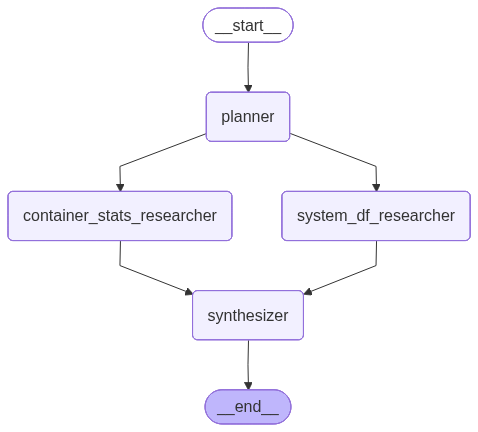

In [39]:
from IPython.display import Image, display

build = StateGraph(DockerState)
retry_policy = RetryPolicy(
    max_attempts=3,
    initial_interval=0.5,
    backoff_factor=2.0,
    jitter=True,
)

build.add_node("planner", planner_node)
build.add_node("container_stats_researcher", container_stats_researcher_node, retry=retry_policy)
build.add_node("system_df_researcher", system_df_researcher_node, retry=retry_policy)
build.add_node("synthesizer", synthesizer_node)

build.set_entry_point("planner")

build.add_edge("planner", "container_stats_researcher")
build.add_edge("planner", "system_df_researcher")

build.add_edge("container_stats_researcher", "synthesizer")
build.add_edge("system_df_researcher", "synthesizer")

app = build.compile()


display(Image(app.get_graph().draw_mermaid_png()))


# Демо
Данные на которых запускается запрос:
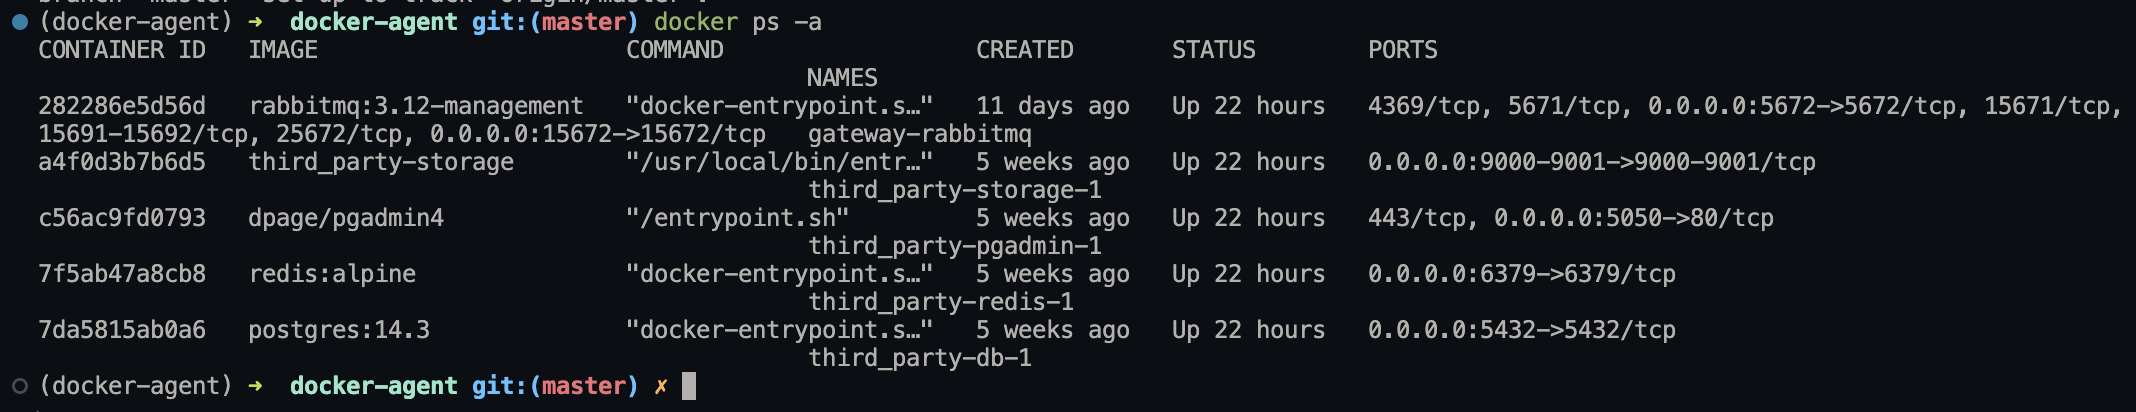

In [40]:
query = DockerQuery(
    task="How much containers is running now?",
)

In [41]:
state = DockerState(query=query)
await app.ainvoke(state)



{'query': DockerQuery(task='How much containers is running now?', include_stopped=False, max_containers=10),
 'plan': DockerPlan(container_queries=['list_containers --filter status=running --limit 10'], system_queries=[], focus_areas=['container status']),
 'container_stats': [],
 'system_df': DockerSystemDF(images=ImagesInfo(type='Images', total=7, active=6, size=SizeInfo(bytes=16307921408, human='15.36 GB'), reclaimable=ReclaimableInfo(size=SizeInfo(bytes=14185373696, human='13.32 GB'), percentage=86.75), inactive=1), containers=ContainersInfo(type='Containers', total=6, active=6, size=SizeInfo(bytes=205363, human='200.70 kB'), reclaimable=ReclaimableInfo(size=SizeInfo(bytes=0, human='0 B'), percentage=0.0), inactive=0, stopped=0), volumes=VolumesInfo(type='Local Volumes', total=23, active=5, size=SizeInfo(bytes=1452063232, human='1.36 GB'), reclaimable=ReclaimableInfo(size=SizeInfo(bytes=1336936448, human='1.25 GB'), percentage=91.57), inactive=18, unused=18), build_cache=BuildCache

# Вывод ужасный, и конечно же мы можем сделать summary из него.


In [ ]:
async def summary_node(state: DockerState) -> dict[str, Any]:
    """Transform the Pydantic report into a beautiful human-readable summary."""
    if not state.report:
        raise ValueError("No report available to summarize")
    
    logger.info("summary: creating human-readable summary")

    key_findings_str = "\n- ".join(state.report.key_findings) if state.report.key_findings else "None"
    recommendations_str = "\n- ".join(state.report.recommendations) if state.report.recommendations else "None"
    
    messages = SUMMARY_PROMPT.format_messages(
        format_instructions=summary_parser.get_format_instructions(),
        task=state.report.task,
        summary=state.report.summary,
        key_findings=key_findings_str,
        recommendations=recommendations_str,
    )
    
    response = await llm.ainvoke(messages)
    summary = summary_parser.parse(response.content)
    
    logger.info("summary: human-readable summary created")
    return {"final_summary": summary}

# Добавим небольшой цикл для повторного синтеза результатов

In [43]:
def should_continue(state: DockerState) -> str:
    max_iterations = 2  
    
    if state.report and state.report.needs_additional_analysis and state.iteration < max_iterations:
        return "container_stats_researcher"  
    return "summary" 

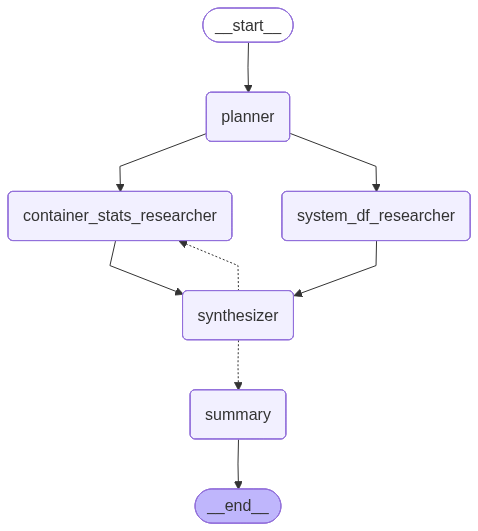

In [44]:
g = StateGraph(DockerState)
g.add_node("planner", planner_node)
g.add_node("container_stats_researcher", container_stats_researcher_node, retry=retry_policy)
g.add_node("system_df_researcher", system_df_researcher_node, retry=retry_policy)
g.add_node("synthesizer", synthesizer_node)
g.add_node("summary", summary_node)

g.set_entry_point("planner")

g.add_edge("planner", "container_stats_researcher")
g.add_edge("planner", "system_df_researcher")

g.add_edge("container_stats_researcher", "synthesizer")
g.add_edge("system_df_researcher", "synthesizer")

g.add_conditional_edges( # просто показать что мы так можем:)
    "synthesizer", 
    should_continue, 
    {
        "container_stats_researcher": "container_stats_researcher", 
        "summary": "summary"
    }
)

g.add_edge("summary", END)

app = g.compile()

display(Image(app.get_graph().draw_mermaid_png()))

# РЕЗУЛЬТАТ

In [45]:
state = DockerState(query=query)
result = await app.ainvoke(state)
result['report'].summary

'The Docker system is currently running 6 containers, all of which are active. There is no indication of performance issues with containers at this time. However, there is significant unused or reclaimable space for Docker images, build cache, and local volumes, which can be cleaned up to free up disk space.'

# 6 контейнеров потому что он считает сам compose 
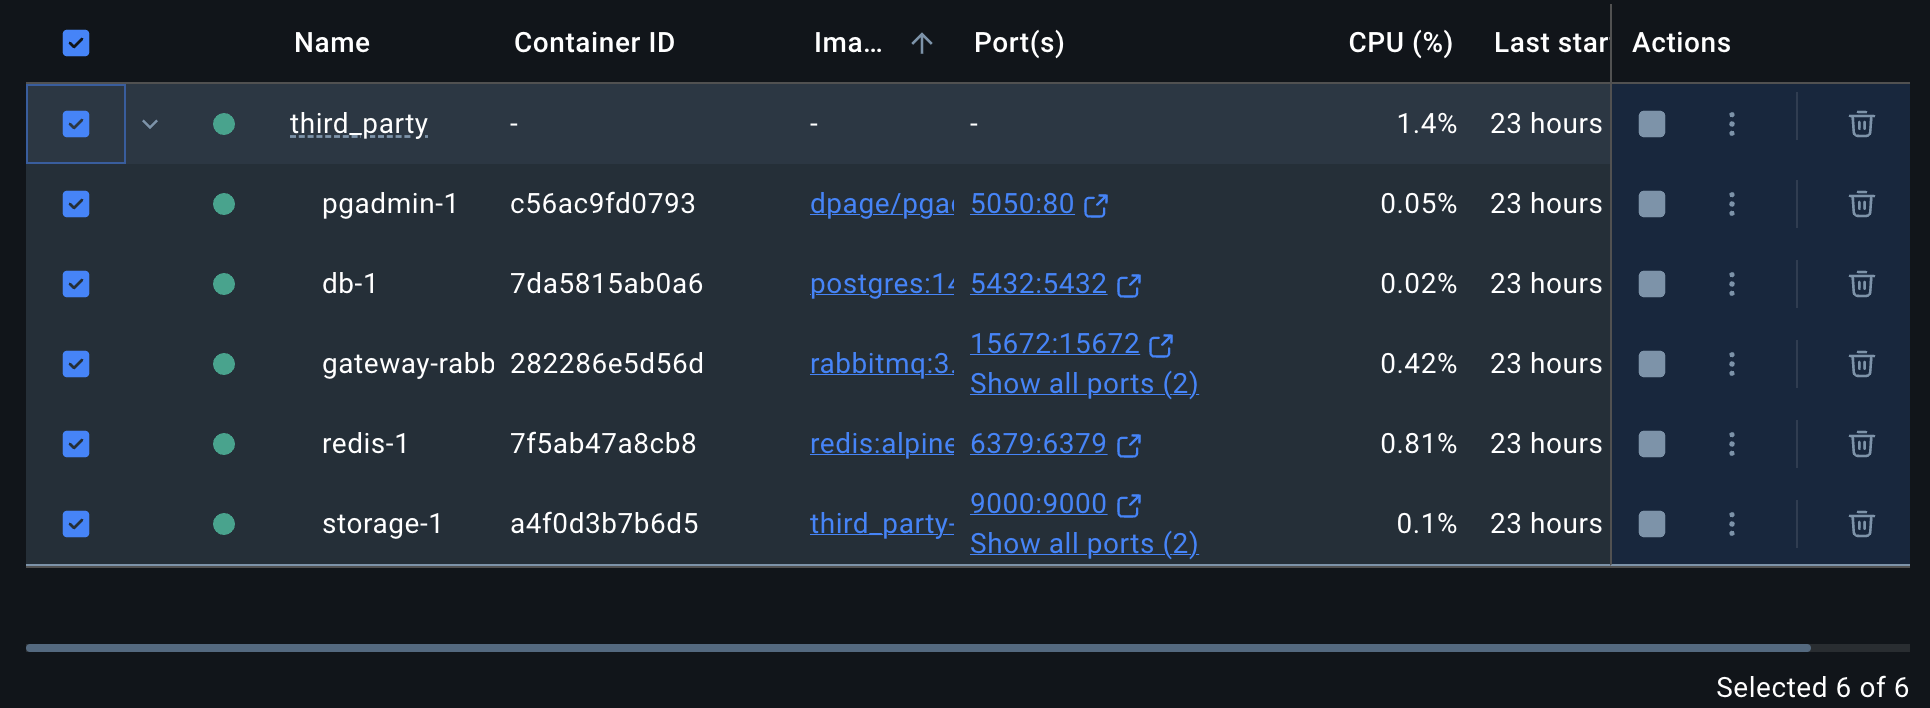

попробуем на задачке посложнее


In [46]:
query = DockerQuery(
    task="Какие порты у моего редиса?",
    include_stopped=True,
    max_containers=8
)

In [47]:
state = DockerState(query=query)
result = await app.ainvoke(state)
result['report'].summary

'В настоящее время недостаточно данных для определения портов Redis, так как статистика контейнеров недоступна. Система содержит несколько запущенных контейнеров и значительное количество ресурсов, которые могут быть очищены.'

# Увы, сильного результата не вышло(
Попробуем на английском

In [48]:
query = DockerQuery(
    task="HostPort of redis container",
    include_stopped=True,
    max_containers=8
)

In [49]:
state = DockerState(query=query)
result = await app.ainvoke(state)
result['report'].summary

'The Docker system is running 6 containers, all of which are active, but no data is available for the redis container, making it impossible to assess its HostPort configuration. The system has significant reclaimable space in Docker images, local volumes, and build cache, which indicates opportunities for cleanup and optimization.'

# Видимо слишком много данных, поэтому агент теряется, потому что сам тул работает

In [50]:
query = DockerQuery(
    task="Free space",
    include_stopped=True,
    max_containers=8
)

In [52]:
state = DockerState(query=query)
result = await app.ainvoke(state)
result

{'query': DockerQuery(task='Free space', include_stopped=True, max_containers=8),
 'plan': DockerPlan(container_queries=['list_containers --all --limit 8', 'container_stats --focus cpu', 'container_stats --focus memory', 'container_stats --focus disk_usage'], system_queries=['system_df --include-stopped', 'system_df --focus disk_usage', 'system_df --focus cleanup_opportunities'], focus_areas=['disk space', 'container status', 'memory consumption', 'CPU usage']),
 'container_stats': [],
 'system_df': DockerSystemDF(images=ImagesInfo(type='Images', total=7, active=6, size=SizeInfo(bytes=16441635840, human='15.36GB'), reclaimable=ReclaimableInfo(size=SizeInfo(bytes=14234022912, human='13.32GB'), percentage=86.75), inactive=1), containers=ContainersInfo(type='Containers', total=6, active=6, size=SizeInfo(bytes=205324, human='200.70kB'), reclaimable=ReclaimableInfo(size=SizeInfo(bytes=0, human='0B'), percentage=0.0), inactive=0, stopped=0), volumes=VolumesInfo(type='Local Volumes', total=23

In [53]:
result["report"].recommendations

['Run `docker image prune -a` to remove all unused images and reclaim 13.32GB of space.',
 'Run `docker system prune` to remove unused containers, networks, and build cache.',
 'Run `docker volume prune` to remove unused local volumes and reclaim 1.25GB of space.',
 'Review and remove any unnecessary Docker build cache using `docker builder prune`.',
 'Schedule regular maintenance to clean up unused Docker resources.']

# Ну вот это уже хорошо